# Generation Time

This notebook is a demonstration of generation time bias and why we're choosing a WF model instead of a nonWF model for our SLiM simulations

In [1]:
import os
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import msprime
import numpy as np
import pyslim
import tskit

In [2]:
TREE_OUT = str(Path("~/simulation-outputs/slim-generation-time").expanduser())
SEED = 23

## Generation Time Bias

Here, I'm reproducing the result from the [pyslim docs](https://web.archive.org/web/20240522192050/https://tskit.dev/pyslim/docs/stable/time_units.html)

In [41]:
mu = 4e-7
Ne = 1000
r = 1e-8

In [42]:
!slim -s {SEED} -d mu={mu} -d K={Ne} -d outfile="'{TREE_OUT}/generation-time.trees'" ~/repo/tskit-ld/spatial-ld/sim/slim/generation-time.slim

// Initial random seed:
23

// RunInitializeCallbacks():
initializeSLiMModelType(modelType = 'nonWF');
initializeSex("A");
initializeTreeSeq();
initializeMutationRate(4e-07);
initializeMutationType(1, 0.5, "f", 0);
initializeGenomicElementType(1, m1, 1);
initializeGenomicElement(g1, 0, 99999);
initializeRecombinationRate(1e-08);
#WARNING (Species::RunInitializeCallbacks): with tree-sequence recording enabled and a non-zero mutation rate, a neutral mutation type was defined and used; this is legal, but usually undesirable, since neutral mutations can be overlaid later using the tree-sequence information.

// Starting run at tick <start>:
1 

Done! Mean generation time 2.50658


In [43]:
ts = tskit.load(f"{TREE_OUT}/generation-time.trees")

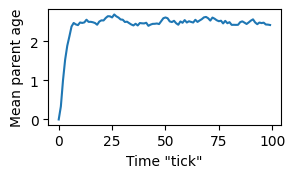

In [44]:
plt.figure(figsize=(3, 1.5))
plt.plot(ts.metadata["SLiM"]["user_metadata"]["generation_times"])
plt.xlabel('Time "tick"')
plt.ylabel("Mean parent age");

In [45]:
gen_times = np.array(ts.metadata["SLiM"]["user_metadata"]["generation_times"])
gt = gen_times[50:100].mean()
gt

2.5065767823335174

In [46]:
ts.diversity(mode="site")

2.8949548885570537e-05

In [47]:
ts.diversity(mode="branch") * mu / gt

3.0713346353589596e-05

In [48]:
rts = pyslim.recapitate(
    ts, recombination_rate=r / gt, ancestral_Ne=Ne * gt, random_seed=SEED
)
mts = msprime.sim_mutations(
    rts,
    rate=mu / gt,
    model=msprime.SLiMMutationModel(type=0),
    keep=True,
    start_time=100,
    random_seed=SEED,
)

/home/lkirk/repo/tskit-ld/ve/lib/python3.12/site-packages/msprime/ancestry.py:1290: TimeUnitsMismatchWarning: The initial_state has time_units=ticks but time is measured in generations in msprime. This may lead to significant discrepancies between the timescales. If you wish to suppress this warning, you can use, e.g., warnings.simplefilter('ignore', msprime.TimeUnitsMismatchWarning)
  sim = _parse_sim_ancestry(


When we recapitate and compute the diversity, the assumptions of the wright-fisher model in msprime 

In [49]:
mts.diversity()

0.0009369349378000223

In [50]:
mts.diversity(mode="branch") * mu / gt

0.0009675050648221161

In [51]:
ts.num_sites

304

In [52]:
mts.num_sites

945

In [15]:
from joblib import Parallel, delayed
def parallel_branch_ld(ts, num_cores, verbose=10, **kwargs):
    if "positions" not in kwargs:
        tril_idx = np.tril_indices(ts.num_trees, k=-1)
        result = np.zeros((ts.num_trees, ts.num_trees), dtype=np.float64)
        bp = list(ts.breakpoints())[:-1]
        tree_range = range(ts.num_trees)
    else:
        bp = list(kwargs.pop("positions"))
        tril_idx = np.tril_indices(len(bp), k=-1)
        result = np.zeros((len(bp), len(bp)), dtype=np.float64)
        tree_range = range(len(bp))

    p = Parallel(
        n_jobs=num_cores, return_as="generator", backend="threading", verbose=verbose
    )
    p_iter = p(
        delayed(ts.ld_matrix)(mode="branch", positions=[[bp[i]], bp[i:]], **kwargs)
        for i in tree_range
    )
    for i, row in zip(tree_range, p_iter):
        result[i, i:] = row
    result[tril_idx] = result.T[tril_idx]
    return result

In [53]:
ld_site = ts.ld_matrix(stat="D2")

In [54]:
ld_branch = ts.ld_matrix(mode="branch", stat="D2", positions=[ts.tables.sites.position])

In [55]:
def get_branch_lengths(ts):
    l = np.array([t.total_branch_length for t in ts.trees()])
    return np.outer(l, l)

In [56]:
lengths = get_branch_lengths(ts)

In [57]:
def positions_to_tree_indices(bp, positions):
    tree_idx = 0
    tree_indices = -np.ones_like(positions, dtype=np.int32)

    for i in range(len(positions)):
        while bp[tree_idx + 1] <= positions[i]:
            tree_idx += 1
        tree_indices[i] = tree_idx

    return tree_indices


def get_index_repeats(indices):
    counts = np.zeros(indices[-1] - indices[0] + 1, dtype=np.int32)
    idx = indices[0]
    count = 1
    for i in range(1, len(indices)):
        if indices[i] == indices[i - 1]:
            count += 1
        else:
            counts[idx - indices[0]] = count
            count = 1
            idx = indices[i]
    counts[idx - indices[0]] = count
    return counts


def position_array(ts, stat_arr, pos):
    idx = positions_to_tree_indices(ts.breakpoints(as_array=True), pos)
    a = np.zeros((len(idx), len(idx)))
    repeats = get_index_repeats(idx)
    row = 0
    for r in range(idx[-1] - idx[0] + 1):
        col = 0
        for c in range(idx[-1] - idx[0] + 1):
            for i in range(repeats[r]):
                for j in range(repeats[c]):
                    a[i + row, j + col] = stat_arr[r, c]
            col += repeats[c]
        row += repeats[r]
    return a

In [58]:
pos_lengths = position_array(ts, lengths, ts.tables.sites.position)

In [59]:
ts.num_trees, ts.num_sites, ts.num_samples, ts.num_sites, ts.sequence_length, Ne, r, mu

(10, 304, 2014, 304, 100000.0, 1000, 1e-08, 4e-07)

In [60]:
(ld_branch / pos_lengths)[np.triu_indices(len(ld_branch), k=1)].mean()

2.5575310387804153e-07

In [61]:
ld_site[np.triu_indices(len(ld_site), k=1)].mean()

2.3559045555869882e-07

In [59]:
distances = np.subtract.outer(ts.tables.sites.position, ts.tables.sites.position)

In [58]:
!slim -s {SEED} -d mu=0 -d K={Ne} -d outfile="'{TREE_OUT}/generation-time-nomut.trees'" ~/repo/tskit-ld/spatial-ld/sim/slim/generation-time.slim

// Initial random seed:
23

// RunInitializeCallbacks():
initializeSLiMModelType(modelType = 'nonWF');
initializeSex("A");
initializeTreeSeq();
initializeMutationRate(0);
initializeMutationType(1, 0.5, "f", 0);
initializeGenomicElementType(1, m1, 1);
initializeGenomicElement(g1, 0, 99999);
initializeRecombinationRate(1e-08);

// Starting run at tick <start>:
1 

Done! Mean generation time 2.47983


In [ ]:
ts = tskit.load(f"{TREE_OUT}/generation-time-nomut.trees")

In [ ]:
rts = pyslim.recapitate(
    ts, recombination_rate=r / gt, ancestral_Ne=Ne * gt, random_seed=SEED
)
mts = msprime.sim_mutations(rts, rate=mu / gt, random_seed=SEED)
ts = msprime.sim_mutations(ts, rate=mu / gt, random_seed=SEED)

Slim with no mutations, msprime mutations added throughout

In [ ]:
ts.diversity(mode="site")

In [ ]:
ts.diversity(mode="branch") * mu / gt

Slim with no mutations, recapitated, tree with msprime mutations added throughout

In [ ]:
mts.diversity(mode="site")

In [ ]:
mts.diversity(mode="branch") * mu / gt

Compare this with ancestry and mutation simulated in msprime

In [ ]:
for t in msprime.sim_ancestry(
    samples=10_000,
    sequence_length=1e8,
    recombination_rate=r,
    population_size=Ne,
    random_seed=SEED,
    num_replicates=10,
):
    t = msprime.sim_mutations(t, rate=mu, random_seed=SEED)

    print("site", t.diversity(mode="site"))
    print("branch", t.diversity(mode="branch") * mu)

Now, let's look at LD

## Wright-Fisher model

Since we want to simulate ancestry in SLiM, but we want accurate estimates of site and branch statistics to demonstrate our LD matrix methods, we'll want to use a Wright-Fisher model. Here, I demonstrate the consistency between the estimates of branch and site statistics.

In [ ]:
!slim -s {SEED} -d mu={mu} -d N={Ne} -d outfile="'{TREE_OUT}/wf-simple.trees'" ~/repo/tskit-ld/spatial-ld/sim/slim/wf-simple.slim

In [ ]:
ts = tskit.load(f"{TREE_OUT}/wf-simple.trees")

In [ ]:
ts.diversity()

In [ ]:
ts.diversity(mode="branch") * mu

In [ ]:
rts = pyslim.recapitate(ts, recombination_rate=r, ancestral_Ne=Ne, random_seed=SEED)
mts = msprime.sim_mutations(
    rts,
    rate=mu,
    model=msprime.SLiMMutationModel(type=0),
    keep=True,
    start_time=100,
    random_seed=SEED,
)

In [ ]:
mts.diversity(mode="site")

In [ ]:
mts.diversity(mode="branch") * mu